# REINFORCE

In [1]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count
from time import time

import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import pandas as pd

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
# torch.autograd.set_detect_anomaly(True)

In [2]:
device_name = "cpu"

if False:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cpu


## Process data

In [ ]:
import sys
sys.path.append("/Users/toshi_pro/Documents/github-sub/machine-learning")
# sys.path.append("/Users/toshi/Documents/school/machine-learning")
# sys.path.append(r"C:\Users\takat\PycharmProjects\machine-learning")
import flowdata
import flowenv

def make_env(phase="train"):
    def _init():
        if phase == "train":
            raw_data_train, raw_data_test = flowdata.flow_data.using_multiple_data()
            return gym.make("flowenv/MultiFlow-v1", data=raw_data_train)
        else:
            raw_data_train, raw_data_test = flowdata.flow_data.using_multiple_data()
            return gym.make("flowenv/MultiFlow-v1", data=raw_data_test)
    return _init

NUM_ENVS = 16

raw_data_train, raw_data_test = flowdata.flow_data.using_data()

In [24]:
train_envs = AsyncVectorEnv([make_env() for _ in range(NUM_ENVS)])
test_env = gym.make("flowenv/MultiFlow-v1", data=raw_data_test)

## Memory

In [4]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Trajectory = namedtuple('Trajectory', ("rewards", "log_probs"))

class EpisodeMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Trajectory(*args))

    def __len__(self):
        return len(self.memory)
    
    # last batch_size memory output
    def sample(self, batch_size):
        return list(self.memory)[-batch_size:]

    def sample_random(self, batch_size):
        return random.sample(self.memory, batch_size)

## Plot rewards

In [5]:
def plot_accuracy(accuracy_list: list, show_result=False):
    if len(accuracy_list) < 1:
        return
    plt.figure(1)
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)
    maximum = np.max(accuracy_list)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title(f"Training... max:{maximum:.3}")
    means = [accuracy_list[0]]
    for i in range(1, len(accuracy_list)):
        if i > 100:
            means.append(np.mean(accuracy_list[i-100:i]))
        else:
            means.append(np.mean(accuracy_list[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("Accuracy")
    plt.xlim(len(accuracy_list)-900, len(accuracy_list)+100)
    # plt.plot(rewards)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Plot Metrics

In [6]:
def plot_metrics(metrics_dict: dict, show_result=False):
    display.clear_output(wait=True)
    fig = plt.figure(figsize=(16, 10))

    ac = fig.add_subplot(3, 2, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(3, 2, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(3, 2, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(3, 2, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(3, 2, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0.0

    if precision < 0:
        precision = 0.0
    if recall < 0:
        recall = 0.0
    return accuracy, precision, recall, f1, fpr

## Network

In [7]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(PolicyNetwork, self).__init__()
        self.common_fc = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.probs = nn.Sequential(
            nn.Linear(128, n_outputs),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.common_fc(x)
        probs = self.probs(x)
        return probs


## Constants

In [8]:
LR = 1e-5
GAMMA = 0.99
BATCH_SIZE = 32

## Variables

In [25]:
num_episodes = 10000

n_inputs = train_envs.single_observation_space.shape[0]
n_outputs = train_envs.single_action_space.n

policy_net = PolicyNetwork(n_inputs, n_outputs).to(device)

optimizer = optim.Adam(policy_net.parameters(), lr=LR)

steps_done = 0
memory = ReplayMemory(1000000)
episode_memory = EpisodeMemory(100000)
returns = []
episode_accuracy = []
episode_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}
episode_rewards = [[] for _ in range(NUM_ENVS)]
episode_log_probs = [[] for _ in range(NUM_ENVS)]

## Functions

In [10]:
def select_action(states):
    states = states.clone().detach().requires_grad_(True)
    probs = policy_net(states)

    distributions = torch.distributions.Categorical(probs)
    actions = distributions.sample()
    log_probs = distributions.log_prob(actions)

    return actions, log_probs

def calculate_returns(rewards):
    returns = torch.zeros_like(rewards)
    G = 0
    try:
        for i in reversed(range(len(rewards))):
            G = rewards[i] + GAMMA * G
            returns[i] = G
    except:
        returns[0] = rewards[0]
    return returns.clone().detach().requires_grad_(True)

def optimize_model():
    # print(log_probs)
    if len(memory) < BATCH_SIZE:
        return
    # trajectory = episode_memory.sample(BATCH_SIZE)
    trajectory = episode_memory.sample_random(BATCH_SIZE)
    batch = Trajectory(*zip(*trajectory))

    rewards = torch.cat(batch.rewards).squeeze()
    log_probs = torch.cat(batch.log_probs).squeeze()

    returns = calculate_returns(rewards)
    baseline = returns.mean()
    advantage = returns - baseline

    loss = -(log_probs * advantage).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

REINFORCE



## Main loop

In [11]:
def test():
    MODEL_PATH = "no4_reinforce.pth"

    # load the model
    trained_network = PolicyNetwork(n_inputs, n_outputs).to(device)
    trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
    trained_network.eval()

    # test the model

    confusion_array = np.zeros((2, 2), dtype=np.int32)
    metrics_dictionary = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "fpr": []
    }

    for i_loop in range(100):
        test_raw_state, _ = test_env.reset()
        test_state = torch.tensor(test_raw_state, device=device, dtype=torch.float32).unsqueeze(0)

        for t in count():
            with torch.no_grad():
                prob_distribution = trained_network(test_state)
                test_action = torch.multinomial(prob_distribution, 1)

            test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

            # calculate confusion matrix
            raw = 0 if test_reward == 1 else 1

            # test_info = (row, column) means confusion matrix index
            index = test_info["confusion_position"]
            confusion_array[index[0], index[1]] += 1

            if test_terminated:
                break

            # make next state tensor and update state
            test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)

        # calculate metrics
        tp = confusion_array[0, 0]
        tn = confusion_array[1, 1]
        fp = confusion_array[0, 1]
        fn = confusion_array[1, 0]

        accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
        metrics_dictionary["accuracy"].append(accuracy)
        metrics_dictionary["precision"].append(precision)
        metrics_dictionary["recall"].append(recall)
        metrics_dictionary["f1"].append(f1)
        metrics_dictionary["fpr"].append(fpr)
        # print(tp, tn, fp, tn)

    return [np.mean(metrics_dictionary["accuracy"]), np.mean(metrics_dictionary["precision"]), np.mean(metrics_dictionary["recall"]), np.mean(metrics_dictionary["f1"]), np.mean(metrics_dictionary["fpr"])]


In [26]:
num_steps = 100000

In [27]:
confusion_matrix = np.zeros((2,2), dtype=int)
sum_reward = 0
# print(i_episode)

seeds = [random.randint(0, 100000) for _ in range(NUM_ENVS)]
#print(seeds)
initial_states, info = train_envs.reset(seed=seeds)
states = torch.tensor(initial_states, device=device, dtype=torch.float32).unsqueeze(0)

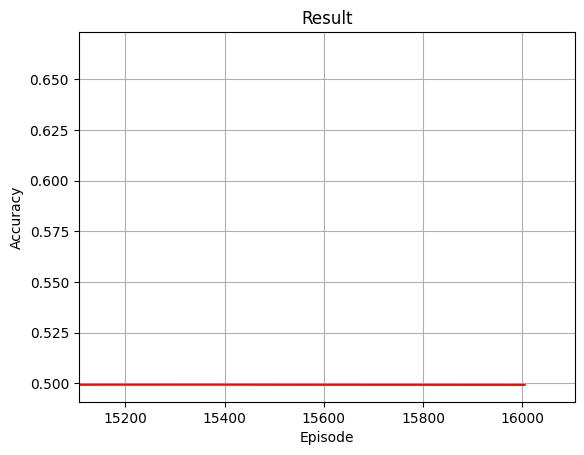

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [28]:
for t in range(num_steps):
    # Select and perform an action
    actions, log_probs = select_action(states)
    actions_np = actions.cpu().numpy()[0]
    train_envs.step_async(actions_np)

    next_states, rewards, terminated, truncated, info = train_envs.step_wait()

    # calculate confusion matrix
    for item in info["confusion_position"]:
        confusion_matrix[item[0], item[1]] += 1

    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)
    for i in range(NUM_ENVS):
        episode_rewards[i].append(rewards[i])

        if terminated[i] or truncated[i]:
            buf_rewards = torch.tensor(episode_rewards[i], dtype=torch.float32)
            buf_log_probs = torch.tensor(episode_log_probs[i], dtype=torch.float32)
            episode_memory.push(buf_rewards, buf_log_probs)
            #print(buf_rewards)
            # one_rewards = torch.cat(buf_rewards)
            # one_log_probs = torch.cat(buf_log_probs)
            # episode_memory.push(one_rewards, one_log_probs)
            episode_rewards = [[] for _ in range(NUM_ENVS)]
            episode_log_probs = [[] for _ in range(NUM_ENVS)]
            next_states, _ = train_envs.reset(seed=random.randint(0, 1000))
            accuracy = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / confusion_matrix.sum()
            episode_accuracy.append(accuracy)
            optimize_model()

    
    # to tensor
    next_states = torch.tensor(next_states, device=device, dtype=torch.float32).unsqueeze(0)

    states = next_states

    # not reuse graph
    if t > 0:
        if t % 25 == 0:
            plot_accuracy(episode_accuracy)
        if t % 5000 == 0:
            print(t)
            torch.save(policy_net.state_dict(), "no4_reinforce.pth")
            ac, pr, re, f1, fp = test()
            with open(f"metrics_{BATCH_SIZE}.csv", "a") as f:
                f.write(f"{t},{ac},{pr},{re},{f1},{fp}\n")
    #print(t)

else:
    torch.save(policy_net.state_dict(), "no4_reinforce.pth")  # save the model
"""
    if i_episode > 0 and i_episode % 100 == 0:
        torch.save(policy_net.state_dict(), "no3_reinforce.pth")  # save the model

        print(f"Episode {i_episode}: {sum_reward}")
        ac, pr, re, f1, fp = test()
        episode_metrics["accuracy"].append(ac)
        episode_metrics["precision"].append(pr)
        episode_metrics["recall"].append(re)
        episode_metrics["f1"].append(f1)
        episode_metrics["fpr"].append(fp)
        plot_metrics(episode_metrics)
"""

# complete the episode
# plot_metrics(episode_metrics, show_result=True)
plot_accuracy(episode_accuracy, show_result=True)

# train_envs.close()

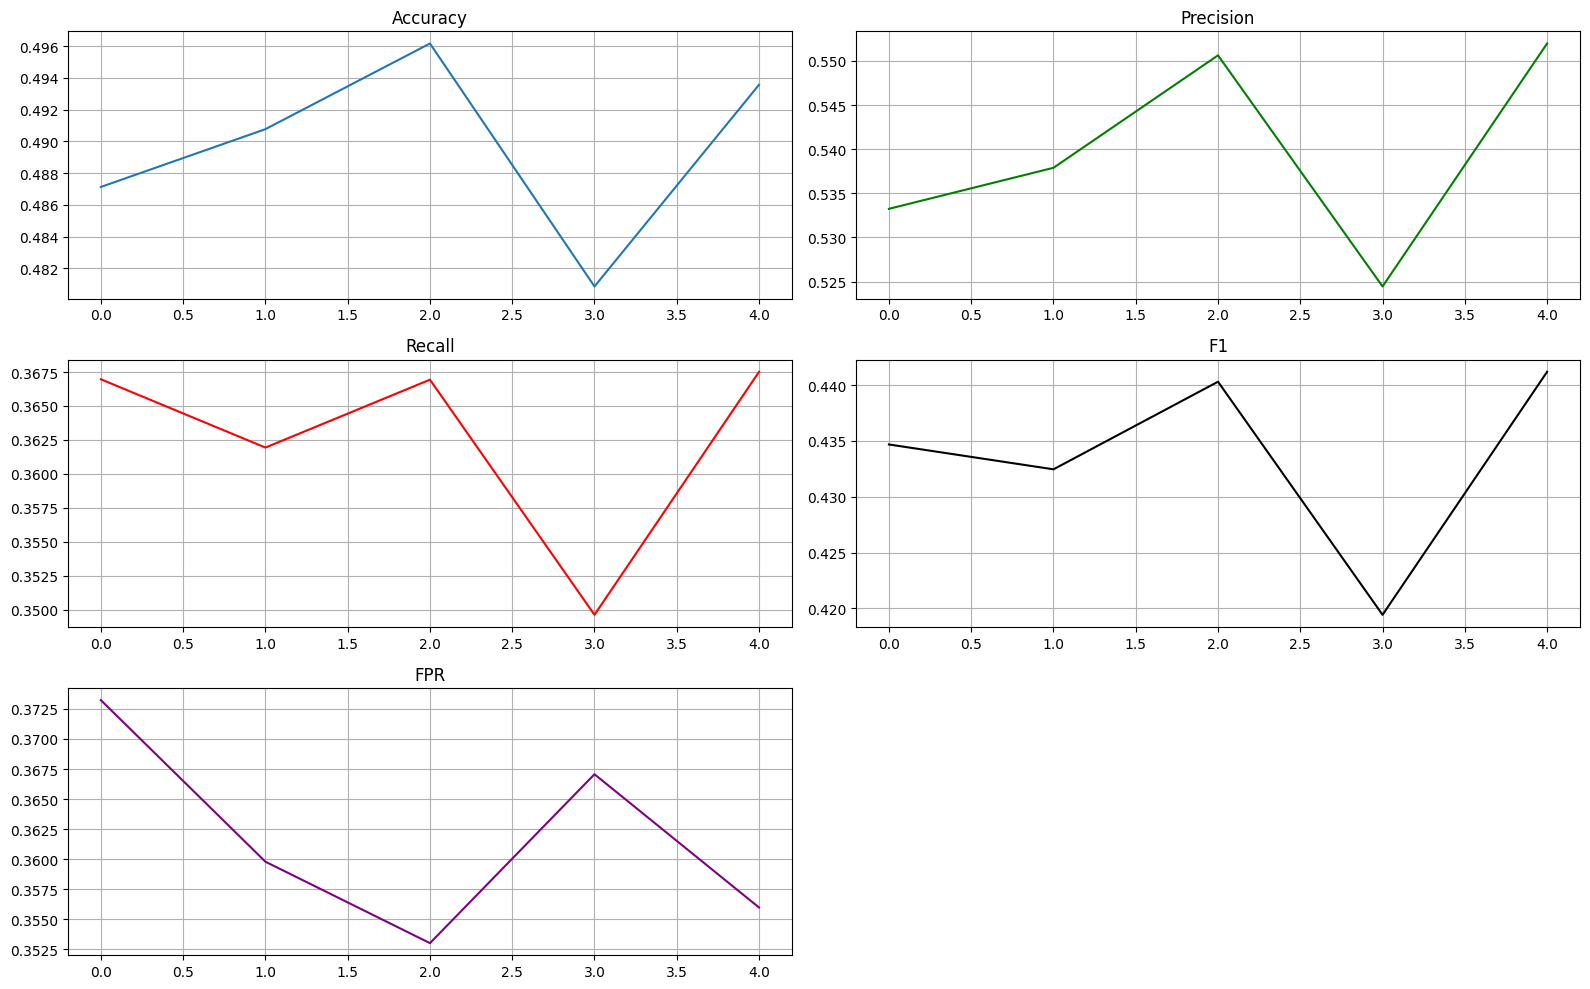

<Figure size 640x480 with 0 Axes>

0.4935649092500495 0.5519725796471004 0.36751550062884775 0.44118496554255876 0.35598341702501074


<Figure size 640x480 with 0 Axes>

In [29]:
#print(f"Episode {i_episode}: {sum_reward}")
for i in range(5):
    ac, pr, re, f1, fp = test()
    episode_metrics["accuracy"].append(ac)
    episode_metrics["precision"].append(pr)
    episode_metrics["recall"].append(re)
    episode_metrics["f1"].append(f1)
    episode_metrics["fpr"].append(fp)
    print(i)
plot_metrics(episode_metrics, show_result=True)
print(ac, pr, re, f1, fp)

## Test the model

In [23]:
for key in episode_metrics.keys():
    print(episode_metrics[key][1])

0.5075305573630206
0.528095360333792
0.37613576970330714
0.43884788131467495
0.35347104708121874
